# MSA 8040 Final Project 

In [1]:
# Imports and PyMongo Setup 
import os
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
import pymongo
from pymongo import MongoClient
print ('Mongo version', pymongo.__version__)
client = MongoClient('localhost', 27017)
db = client.reviews
collection = db.full 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import re
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score
import pickle



Mongo version 3.7.2
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Paul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
# Imports without PyMongo
import os
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import re
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score
import pickle
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /Users/Work/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
#read df2 if not connected to MongoDB Server
#df2 = pd.read_pickle('review_data.pkl')

In [ ]:
# Reading in for MongoDB
df2 = pd.DataFrame(columns=['_id','bubble','hotel_name','review','url'])
res = collection.find() # return a cursor
df2 = pd.DataFrame(list(res)) # use list to turn the cursor to an array of documents
df2.set_index('_id')
#Getting the pure rating 
df2['rating']=df2['bubble'].apply(lambda x: x[-2:-1] if x[-2:-1] != 'O' else -1)
df2.head()
#Saving Dataframe to pickle file to be read later 
df2.to_pickle('review_data.pkl')



In [47]:
# converting column to list 
corpus = df2['review'].tolist()

In [48]:
# Using Regular Expressions to remove \ in the text for each review
corpus = [re.sub('\s+', ' ', sent) for sent in corpus]

In [49]:
# Declaring Stopwords
stop_words = stopwords.words('english')
# Extending Stopwords to include very common words that we already know
stop_words.extend(['hotel','atlanta'])

# Initializes the preprocessing
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=stop_words,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
 )
# looking at the features 
features = vectorizer.fit_transform(corpus).todense()
print(vectorizer.fit_transform(corpus).todense())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# Testing various ranges of clusters to find the elbow using inertia 
range_n_clusters= range(10,101,10)
sse = []
for n_clusters in range_n_clusters:
    kmeans_model= KMeans(n_clusters).fit(features)
    sse.append(kmeans_model.inertia_)
    print(n_clusters)

Text(0.5,0.98,'How to choose the Number of clusters for KMeans')

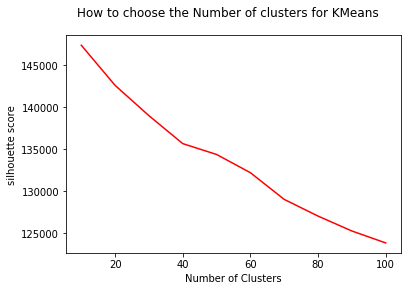

In [65]:
# Plotted from 10-100, see an elbow at 40
import matplotlib.pyplot as plt
from matplotlib.collections import EventCollection
fig = plt.plot(range_n_clusters,sse,'-r')
plt.xlabel('Number of Clusters')
plt.ylabel('silhouette score')
plt.suptitle('How to choose the Number of clusters for KMeans')


In [82]:
# Now using Tf-idf for our preprocessing while also using the k-value from above 
vectorizer = TfidfVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=stop_words,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}'  # num chars > 3
                            )
X=vectorizer.fit_transform(corpus)
true_k = 40

# Loads in old model when I first ran this
filename = 'review.sav'
rev_model = pickle.load(open(filename, 'rb'))

# Make new model
#rev_model = KMeans(n_clusters=true_k,init='k-means++',max_iter=100,n_init=1)
#rev_model.fit(X)

# Dumped the model to a pickle file to have consistent model in future
filename = 'review.sav'
#pickle.dump(rev_model, open(filename, 'wb'))

print(X.shape) 


(3000, 1904)


In [83]:
## Assigning each review a cluster
clusters = pd.DataFrame(columns=['review','hotel','cluster'])
views =[]
clus = []
hote = []
for i in range(0,len(df2['review'])):
    # Goes through each review, vectorize it, then predict it with our model
    rev = df2['review'].iloc[i]
    hot = df2['hotel_name'].iloc[i]
    Y = vectorizer.transform([rev])
    prediction = rev_model.predict(Y)
    hote.append(hot)
    views.append(rev)
    clus.append(prediction)
clusters['review'] = views
clusters['cluster'] = clus
clusters['hotel']=hote
clusters['cluster'] = clusters['cluster'].apply(lambda x: x[0])
clusters.head()


,review,hotel,cluster
0,We spent 5 nights at the Westin Peachtree over...,"The Westin Peachtree Plaza, Atlanta Hotel",25
1,I want to start my review by saying that it is...,"The Westin Peachtree Plaza, Atlanta Hotel",21
2,This hotel has been our go-to for several year...,"The Westin Peachtree Plaza, Atlanta Hotel",21
3,This hotel was excellent in every way. We had ...,"The Westin Peachtree Plaza, Atlanta Hotel",14
4,The stay was great I we were very disappointed...,"The Westin Peachtree Plaza, Atlanta Hotel",33


In [84]:
# Grouping by cluster and hotels and having a count of the # of reviews
counts = clusters.groupby(['hotel','cluster']).count().reset_index()
counts.head()


,hotel,cluster,review
0,AC Hotel Atlanta Buckhead at Phipps Plaza,1,3
1,AC Hotel Atlanta Buckhead at Phipps Plaza,3,2
2,AC Hotel Atlanta Buckhead at Phipps Plaza,5,2
3,AC Hotel Atlanta Buckhead at Phipps Plaza,7,4
4,AC Hotel Atlanta Buckhead at Phipps Plaza,8,1


In [85]:
# getting max # of review for hotel cluster to be the "Representative" of that cluster
get_max = pd.DataFrame(counts.groupby(['hotel'])['review'].max()).merge(counts,left_on = 'hotel', right_on = 'hotel', how = 'left')
len(get_max['cluster'].unique())


40

In [86]:
# Final is table with individual hotel and their cluster
final = get_max[get_max['review_x']==get_max['review_y']][['hotel','cluster']]
final
print(len(final['cluster'].unique()))
final.to_csv('review_final.csv')

36


In [88]:
#DEMO with just review 

test = input()
Y = vectorizer.transform([test])
prediction = rev_model.predict(Y)
pd.DataFrame(final[final['cluster']==prediction[0]]['hotel'].unique())

We stayed here for x2 nights at the end of a recent road tour. The hotel location is excellent and can be reached by MARTA from the airport to the Peachtree station. Our room was on the 27th floor so we had a restricted view of the city, but was clean and comfortable.Great location for access to the Falcons amazing stadium , plusalso the College hall of fame and Coca- Cola world.check out is at 1200 but as we had a later flight we're able to hang on until 1400 which helped significantly.'


,0
0,AC Hotel Atlanta Downtown
1,Embassy Suites by Hilton Atlanta - at Centenni...
2,"Glenn Hotel, Autograph Collection, Atlanta"
3,Hampton Inn & Suites Atlanta - Downtown Hotel
4,Omni Atlanta Hotel at CNN Center
5,SpringHill Suites Atlanta Downtown Hotel
6,"The Westin Peachtree Plaza, Atlanta Hotel"


# Hotel Data

In [56]:
## Reading the file from *.csv
df_specs = pd.read_csv("TA_Hotel_Specs.csv") 
df_specs.head()

,Unnamed: 0,HotelName,HotelURL,BubbleRating out of 5,ReviewCount,Price$,Breakfast included,Free Internet,Free Parking,Room Service,Visit hotel website,Free Wifi,Restaurant,Pool
0,0,Homewood Suites by Hilton Atlanta - Cumberland...,/Hotel_Review-g60898-d223010-Reviews-Homewood_...,4.0,758,179,0,0,1,0,1,1,0,0
1,1,"The Westin Peachtree Plaza, Atlanta",/Hotel_Review-g60898-d114387-Reviews-The_Westi...,4.0,3227,158,0,0,0,0,1,0,1,1
2,2,Holiday Inn & Suites Atlanta Airport - North,/Hotel_Review-g60898-d86197-Reviews-Holiday_In...,4.5,837,82,0,0,0,0,1,1,0,1
3,3,Grand Hyatt Atlanta in Buckhead,/Hotel_Review-g60898-d86179-Reviews-Grand_Hyat...,4.5,2322,139,0,0,0,0,1,1,0,1
4,4,Wingate by Wyndham Atlanta/Buckhead,/Hotel_Review-g60898-d223001-Reviews-Wingate_b...,4.5,2476,119,0,0,1,0,0,1,0,0


In [57]:
# Drop random column
df_specs1 = df_specs.drop(['Unnamed: 0'],axis = 1)
# Drop all columns not numeric
df_quant = df_specs1.iloc[:,2:]
# Drop Price 
df_quant.drop('Price$',axis=1,inplace=True)

In [58]:
from sklearn.preprocessing import StandardScaler  # For scaling dataset
#Scaling of data
ss = StandardScaler()
scaled_feature = ss.fit_transform(df_quant.values)

In [59]:
df_scaled_quant = pd.DataFrame(scaled_feature,index = df_quant.index, columns = df_quant.columns)


In [31]:
# Checking again for the elbow
range_n_clusters = range(10, 101, 10)
from sklearn.cluster import KMeans
sse = []
for n_clusters in range_n_clusters:
    kmeans_model = KMeans(n_clusters=n_clusters).fit(df_scaled_quant)
    #sse[n_clusters-2] = kmeans_model.inertia_
    sse.append(kmeans_model.inertia_)
    print(n_clusters)

10
20
30
40
50
60
70
80
90
100


Text(0.5,0.98,'How to choose the Number of clusters for KMeans')

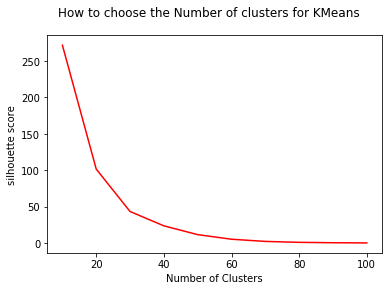

In [80]:
import matplotlib.pyplot as plt
from matplotlib.collections import EventCollection
fig = plt.plot(range_n_clusters,sse,'-r')
plt.xlabel('Number of Clusters')
plt.ylabel('silhouette score')
plt.suptitle('How to choose the Number of clusters for KMeans')


In [63]:
from sklearn.cluster import KMeans
df_specs['cluster'] = np.nan

#HOW TO RELOAD MODEL from before
filename = 'hotel.sav'
model = pickle.load(open(filename, 'rb'))

#model = KMeans(n_clusters=30,init='k-means++',max_iter=100,n_init=1)
model.fit(df_scaled_quant)
model.cluster_centers_


#pickle.dump(model, open(filename, 'wb'))

for i in range(0,len(df_scaled_quant)):
    predictions = model.predict([df_scaled_quant.iloc[i]])
    df_specs['cluster'].iloc[i] = predictions


/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [72]:
df2['name_match'] =df2['hotel_name'].apply(lambda x: x[:-6] if x[-6:]== ' Hotel' else x)
df_specs['name_match']=df_specs['HotelName'].apply(lambda x: x[:-6] if x[-6:]== ' Hotel' else x)
df2.to_csv('demo_df2.csv')
df_specs.to_csv('demo_df_specs.csv')

In [66]:
def demo(rating,popularity,breakfast,internet,parking,room_service,hotel_web,
        wifi,resturant,pool,test):
    """
    This method is the demo, it'll require the inputs for the hotel and a review
    """
    # Makes sure same vectorization happens to input review as other review
    Y = vectorizer.transform([test])
    # Makes a prediction which cluster it belongs in 
    prediction = rev_model.predict(Y)
    # Saves all hotel in the same cluster to rev
    rev = pd.DataFrame(final[final['cluster']==prediction[0]]['hotel'].unique(),columns=['HotelName'])
    # Makes a prediction which cluster for the hotel data
    prediction = model.predict([[rating,popularity,breakfast,internet,parking,room_service,hotel_web,wifi,resturant,pool]])
    # Saves all hotel in the same cluster to new
    new = df_specs[df_specs['cluster']==prediction[0]][['HotelName','Price$']].sort_values('Price$')
    # Now going to merge the two tables and bring in the Prices for these hotels
    hotel_matching = new.merge(df_specs[['HotelName','name_match']])[['name_match','Price$']]
    review_matching = rev.merge(df2[['hotel_name','name_match']],
          how='left',left_on='HotelName',right_on = 'hotel_name'
         ).drop_duplicates('HotelName').merge(
            df_specs[['name_match','Price$']],on='name_match'
            )[['name_match','Price$']]
    # Concat tables, then drop duplicates 
    results = pd.concat([hotel_matching,review_matching]).drop_duplicates('name_match').reset_index().iloc[:,1:]
    # Sorted by price, low to high
    results = results.rename(columns={'name_match':'Hotel Name','Price$':'Price'}).sort_values('Price').set_index('Hotel Name')
    # Returns a table
    return results


# Demo

In [99]:
rating = float(input("Rating [0,1]: "))
popularity = float(input("Popular? [0,1]: "))
print("\n Yes = 1, No = 0\n")
breakfast = float(input("Breakfast: "))
internet = float(input("Internet: "))
parking = float(input("Parking: "))
room_service = float(input("Room Service: "))
hotel_web = float(input("Hotel Website: "))
wifi = float(input("WiFi: "))
resturant = float(input("Resturant: "))
pool = float(input("Pool: "))
print("\nNow Input your Review\n")
test = input("\nReview: ")

demo(rating,popularity,breakfast,internet, parking,room_service,
    hotel_web,wifi,resturant,pool,test)

Rating [0,1]: 1
Popular? [0,1]: 1

 Yes = 1, No = 0

Breakfast: 1
Internet: 0
Parking: 1
Room Service: 1
Hotel Website: 1
WiFi: 1
Resturant: 0
Pool: 0

Now Input your Review


Review: Sucks!


,Price
Hotel Name,
Holiday Inn Express & Suites Atlanta Airport West - Camp Creek,82
La Quinta Inn & Suites Atlanta Ballpark/Galleria,89
Crowne Plaza Atlanta - Midtown,105
Drury Inn & Suites Atlanta Airport,110
La Quinta Inn & Suites Atlanta Airport North,114
Hilton Garden Inn Atlanta NW/Wildwood,117
Hampton Inn & Suites Atlanta Perimeter Dunwoody,118
Homewood Suites by Hilton Atlanta Airport North,129
Atlanta Marriott Century Center/Emory Area,139
